In [1]:
# define experiment parameters

# [-500 ~ 500]
WL=0; WW=1000

In [2]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Read Dicom

In [3]:
def read_dicom(path):
    g = glob.glob(os.path.join(path, '*.dcm'))
    slices = [pydicom.read_file(s) for s in g]
    slices.sort(key=lambda x: int(x.InstanceNumber))
#     print('RescaleIntercept :{}'.format(slices[0].RescaleIntercept))
#     print('RescaleSlope :{}'.format(slices[0].RescaleSlope))
#     print('SliceThickness :{}'.format(slices[0].SliceThickness))
#     print('Pixel Spacing  :{}'.format(slices[0].PixelSpacing ))

    return slices

In [4]:
def hu_window(scan, window_level=40, window_width=80, show_hist = False):
    scan = scan.pixel_array.copy()
    window = [window_level-window_width/2, window_width/2-window_level]
    
    scan = np.where(scan < window[0], window[0], scan)
    scan = np.where(scan > window[1], window[1], scan)
    
    if show_hist:
        plt.figure(0, figsize=(6,6))
        plt.imshow(scan, 'gray')

        plt.figure(1, figsize=(6,6))
        plt.hist(scan.flatten(), color='c')
        plt.xlabel("Hounsfield Units (HU)")
        plt.ylabel("Frequency")
        plt.show()

    return scan

In [5]:
def show_raw_pixel(slices):
    #讀出像素值並且儲存成numpy的格式
    image = hu_window(slices, window_level=0, window_width=1000,  show_hist=False)
#     plt.figure(figsize = (12,12))
    plt.imshow(image, cmap=plt.cm.gray)
    plt.show()

In [6]:
# return  a region where cbct images aren't all black
def valid_slices(cbcts, cts):
    found_start = False
    start = 0
    end = -1
    
    # iterate through cbct slices, and find which regions aren't all black (-1000)
    for idx, sli in enumerate(cbcts):
        image = sli.pixel_array
        
        if not found_start and len(np.unique(image))!=1:
            start = idx
            found_start = True
                                   
        elif found_start and len(np.unique(image)) == 1:
            end = idx
            break
        
    return start, end
                                   

## read two slices

In [7]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [9]:
class Dataset(BaseDataset):
    """
    Args:
        path (str): path to dataset
        x_channel (int): number of channels for X(images)
        y_channel (int): number of channels for y(masks)
        do_resize (tuple of ints): resize the image and mask, if None, DO NOT do resize
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self,
            path,
    ):
        paths = sorted(glob.glob(path))
        self.xs = []
        self.ys = []
        
        # read cbct and ct
        for i in range(0, len(paths), 2):
            cbct_slices = read_dicom(paths[i])
            ct_slices = read_dicom(paths[i+1])

            region = valid_slices(cbct_slices, ct_slices)
            # ditch first and last 3
            self.xs = self.xs + cbct_slices[region[0] + 3: region[1] - 3]
            self.ys = self.ys + ct_slices[region[0] + 3: region[1] - 3]
            
        # set both cbct and ct to same WL and WW (0, 1000)
        self.xs = [hu_window(cbct, window_level=WL, window_width=WW,  show_hist=False) for cbct in self.xs]
        self.ys = [hu_window(ct, window_level=0, window_width=1000,  show_hist=False) for ct in self.ys]
        
    
    def __getitem__(self, i):

        # read img
        x = self.xs[i]
        y = self.ys[i]
        
        x = np.expand_dims(x, 0).astype(np.float32)
        y = np.expand_dims(y, 0).astype(np.float32)
        
        crop_size = (64, 448)
        x = x[:, crop_size[0]:crop_size[1], crop_size[0]:crop_size[1]]
        y = y[:, crop_size[0]:crop_size[1], crop_size[0]:crop_size[1]]

        return x, y
        
    def __len__(self):
        return len(self.xs)

In [10]:
trainset = Dataset(train_case_path)
testset = Dataset(test_case_path)

In [11]:
len(trainset), len(testset)

(1344, 191)

In [12]:
x, y = trainset[20]

(<matplotlib.image.AxesImage at 0x7f3edd40d7f0>,)

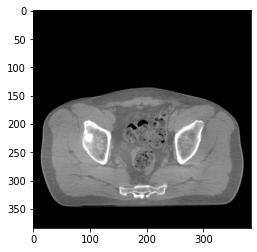

In [13]:
plt.imshow(x.squeeze(), 'gray'),

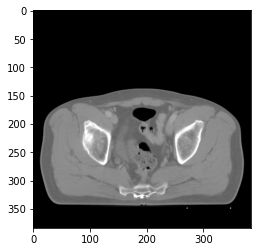

In [14]:
plt.imshow(y.squeeze(), 'gray')

In [15]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

In [16]:
x, y = testset[4]

(<matplotlib.image.AxesImage at 0x7f3edd4054a8>,)

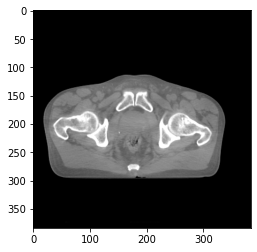

In [17]:
plt.imshow(x.squeeze(), 'gray'),

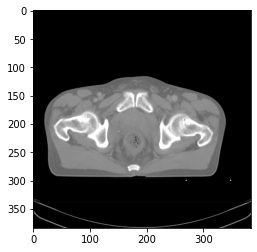

In [18]:
plt.imshow(y.squeeze(), 'gray')

# training

In [19]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

In [20]:
class MAELoss(nn.L1Loss):
  def __init__(self):
    nn.L1Loss.__init__(self)
    self.__name__ = 'mae_loss'

In [21]:
loss = MAELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [22]:
train_loaders = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loaders = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [24]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(encoder_name='se_resnet152', encoder_weights=None, in_channels=1, classes=1)

DEVICE = 'cpu'
if torch.cuda.is_available():
  print('using gpu')
  DEVICE = 'cuda'
  model.cuda()
else:
  print('using cpu')

using gpu


In [25]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=3e-4),
])

In [26]:

# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [27]:

from torchsummary import summary

if torch.cuda.is_available():
  summary(model.cuda(), (1, 512, 512))
else:
  summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,136
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [28]:
save_model_path = 'save_model_unet_se_resnet152.pth'

In [29]:
mse_loss = []

In [30]:
EPOCH = 200
min_error = 999

for i in range(EPOCH):
    
    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_loaders)
    valid_logs = valid_epoch.run(test_loaders)

    # save dice loss
    mse_loss.append(valid_logs['mae_loss'])

    if i == 750:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
        
    if min_error > valid_logs['mae_loss']:
        min_error = valid_logs['mae_loss']
        torch.save(model.state_dict(), save_model_path)
        
    if i % 20 == 0:
        torch.save(model.state_dict(), '{}epoch_{}'.format(i, save_model_path))


Epoch: 0
valid: 100%|██████████| 48/48 [00:03<00:00, 12.56it/s, mae_loss - 298.4, iou_score - -0.07387]

Epoch: 1
valid: 100%|██████████| 48/48 [00:03<00:00, 12.54it/s, mae_loss - 286.1, iou_score - -0.07471]

Epoch: 2
valid: 100%|██████████| 48/48 [00:03<00:00, 12.37it/s, mae_loss - 273.3, iou_score - -0.07357]

Epoch: 3
valid: 100%|██████████| 48/48 [00:03<00:00, 12.30it/s, mae_loss - 252.9, iou_score - -0.07429]

Epoch: 4
valid: 100%|██████████| 48/48 [00:03<00:00, 12.25it/s, mae_loss - 232.7, iou_score - -0.07412]

Epoch: 5
valid: 100%|██████████| 48/48 [00:03<00:00, 12.22it/s, mae_loss - 208.6, iou_score - -0.07475]

Epoch: 6
valid: 100%|██████████| 48/48 [00:03<00:00, 12.22it/s, mae_loss - 180.7, iou_score - -0.07343]

Epoch: 7
valid: 100%|██████████| 48/48 [00:03<00:00, 12.11it/s, mae_loss - 152.9, iou_score - -0.07468]

Epoch: 8
valid: 100%|██████████| 48/48 [00:03<00:00, 12.05it/s, mae_loss - 124.2, iou_score - -0.07474]

Epoch: 9
valid: 100%|██████████| 48/48 [00:03<00:00, 1

In [31]:
np.min(mse_loss)

17.63927376270294

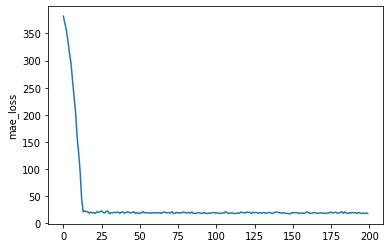

In [32]:
plt.plot(mse_loss)
plt.ylabel('mae_loss')
plt.show()

In [33]:
len(testset)

191

# Testing

In [34]:
def cliphu(img, wl, ww):
    '''
    clip the window level
    '''
    img[img < (wl-ww)/2] = (wl-ww)/2
    img[img > (wl+ww)/2] = (wl+ww)/2
    
    return img

In [35]:
x,y = testset[26]

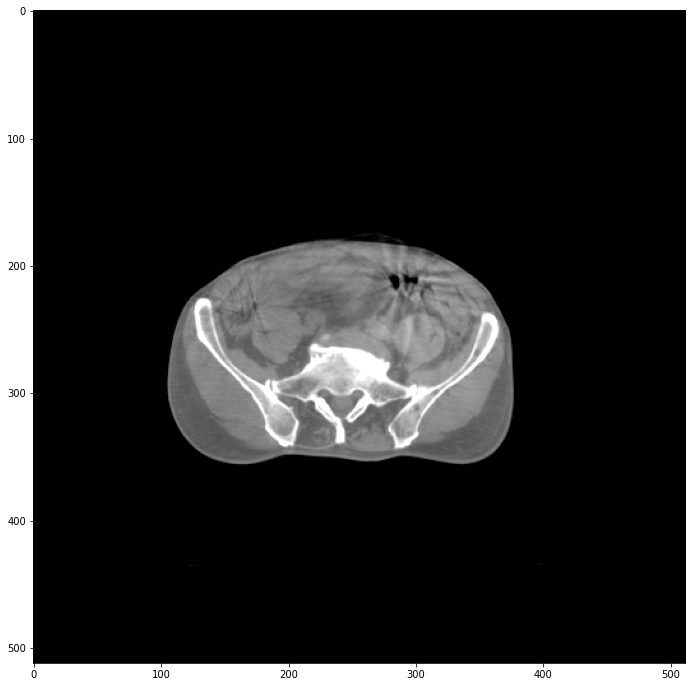

In [36]:
plt.figure(figsize=(12,12))
plt.imshow(x.squeeze(), 'gray')

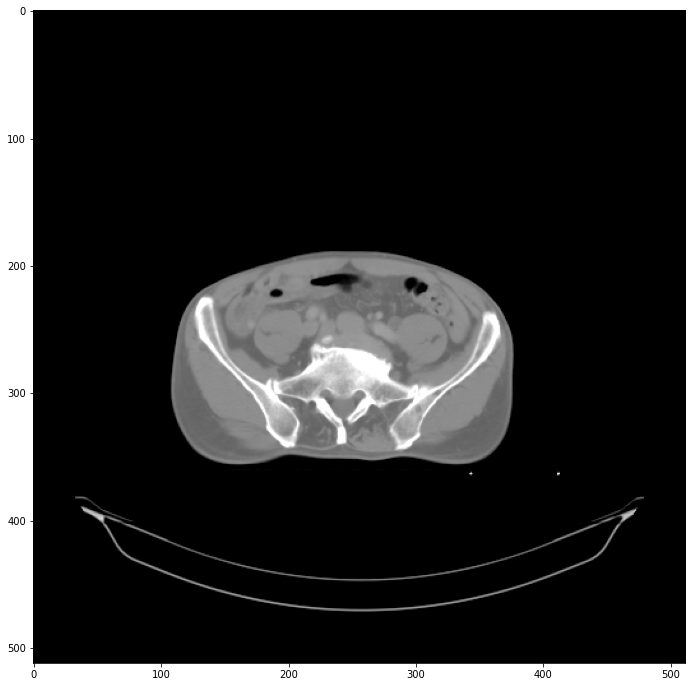

In [37]:
plt.figure(figsize=(12,12))
plt.imshow(y.squeeze(), 'gray')

In [39]:
model.load_state_dict(torch.load('save_model_unet_se_resnext.pth'))
model.eval()
print('eval mode')

eval mode


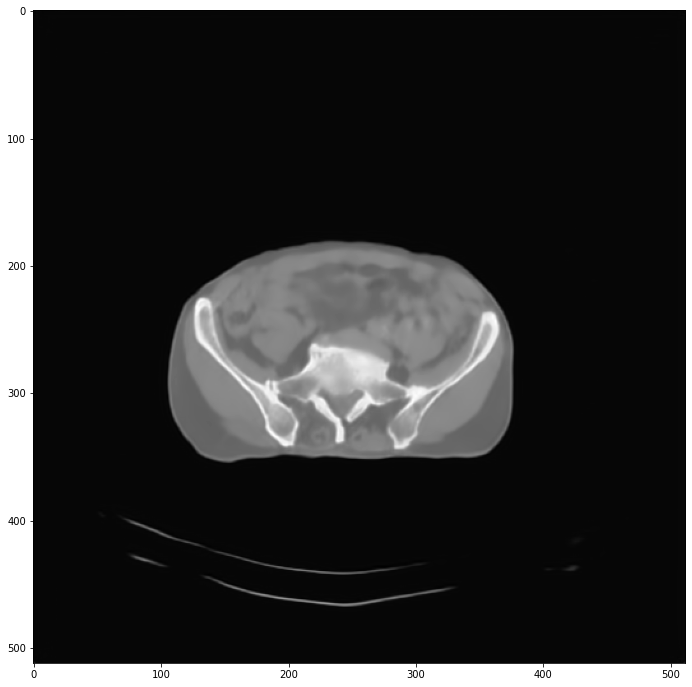

In [40]:
with torch.no_grad():
    pred = model(torch.tensor(x).unsqueeze(0).cuda())
    
    pred_img = pred.cpu().squeeze().numpy()
    
plt.figure(figsize=(12,12))
plt.imshow(pred_img, 'gray')

In [41]:
x,y = testset[5]

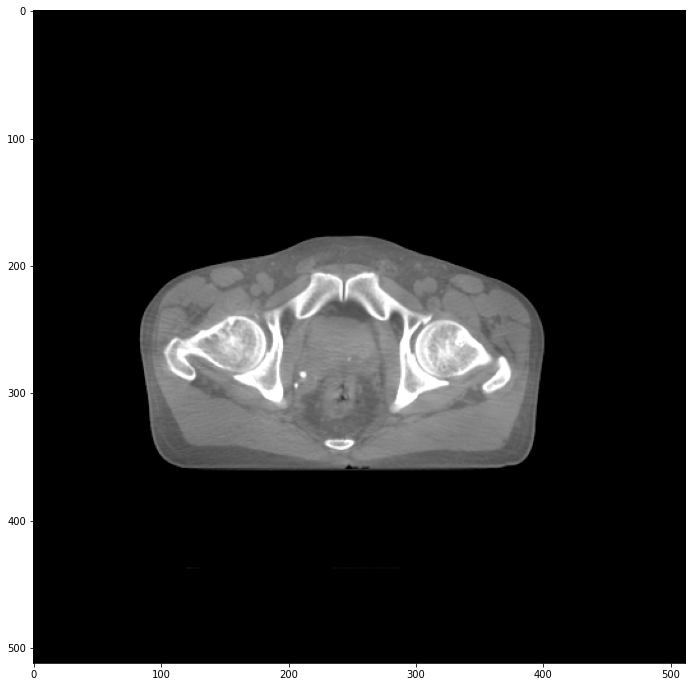

In [42]:
plt.figure(figsize=(12,12))
plt.imshow(x.squeeze(), 'gray')

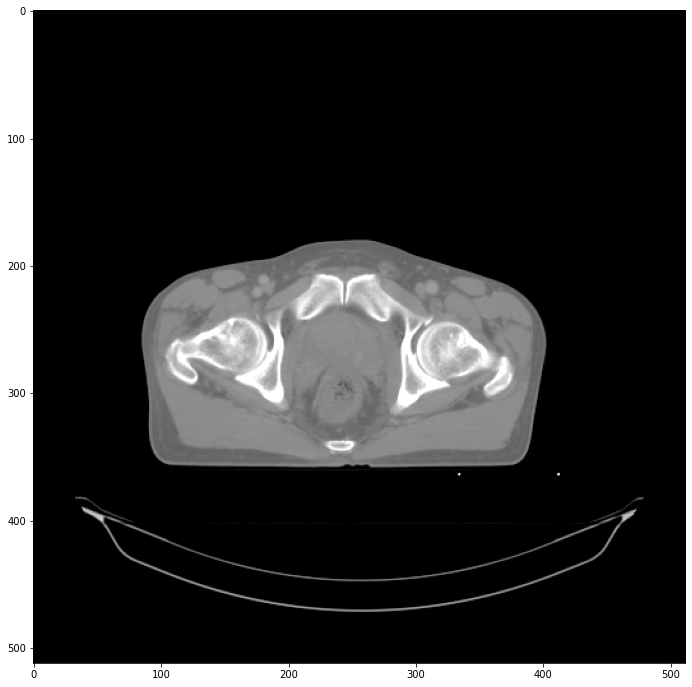

In [43]:
plt.figure(figsize=(12,12))
plt.imshow(y.squeeze(), 'gray')

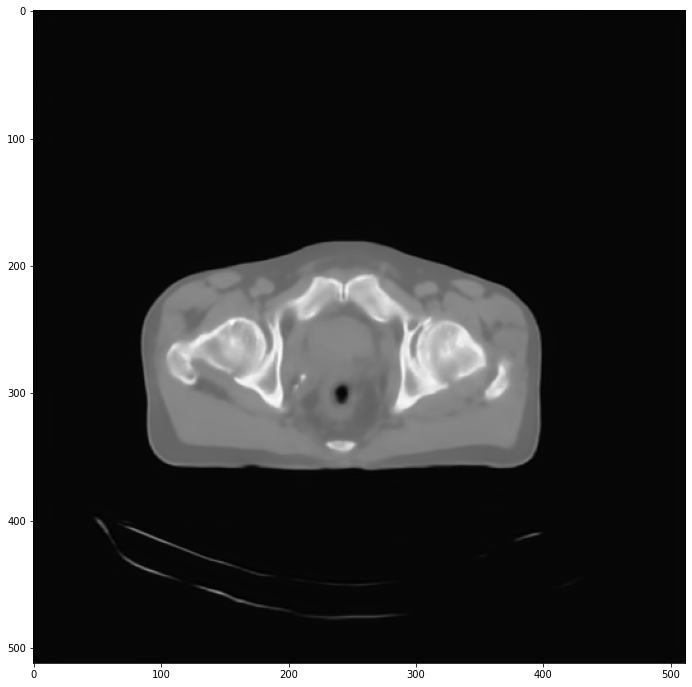

In [44]:
with torch.no_grad():
    pred = model(torch.tensor(x).unsqueeze(0).cuda())
    
    pred_img = pred.cpu().squeeze().numpy()
    
plt.figure(figsize=(12,12))
plt.imshow(pred_img, 'gray')

## inference through the testset

In [78]:
from tqdm import tqdm

In [79]:
test_result_path = 'data/results/'

In [80]:
idx = 0
for x, y in tqdm(testset):
    with torch.no_grad():
        pred = model(torch.tensor(x).unsqueeze(0).cuda())

        pred_img = pred.cpu().squeeze().numpy()
        
        # normalize to image
        r = ((pred_img-np.min(pred_img))/(np.max(pred_img)-np.min(pred_img)) * 255).astype(np.uint8)
        _y = ((y+500)/1000 * 255).astype(np.uint8)
        _x = ((x+500)/1000 * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(test_result_path, 'reconstructed/{}_pr.png'.format(idx)), r)
        cv2.imwrite(os.path.join(test_result_path, 'gt/{}_y.png'.format(idx)), _y.squeeze())
        cv2.imwrite(os.path.join(test_result_path, 'origin/{}_x.png'.format(idx)), _x.squeeze())
        idx+=1

100%|██████████| 191/191 [00:13<00:00, 14.25it/s]


In [81]:
np.min(pred_img), np.max(pred_img)

(-543.1984, 584.7396)

In [82]:
np.min(y), np.max(y)

(-500.0, 500.0)

In [83]:
np.min(x), np.max(x)

(-500.0, 500.0)